In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# -------------------------------------------------------
# MIXED PRECISION
# -------------------------------------------------------
mixed_precision.set_global_policy("mixed_float16")

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# -------------------------------------------------------
# PATHS — ONLY UPDATE BASE
# -------------------------------------------------------
BASE = "/run/media/ShaunakMishra25/Acer/Users/Shaunak Mishra/Desktop/CB/AI ML/BRISC/archive/brisc2025/segmentation_task"

TRAIN_IMAGES_DIR = f"{BASE}/train/images"
TRAIN_MASKS_DIR  = f"{BASE}/train/masks"

TEST_IMAGES_DIR  = f"{BASE}/test/images"
TEST_MASKS_DIR   = f"{BASE}/test/masks"

VAL_IMAGES_DIR   = f"{BASE}/val/images"
VAL_MASKS_DIR    = f"{BASE}/val/masks"

# -------------------------------------------------------
# ENSURE VAL FOLDERS EXIST
# -------------------------------------------------------
for d in [VAL_IMAGES_DIR, VAL_MASKS_DIR]:
    if not os.path.exists(d):
        os.makedirs(d)
        print("Created:", d)

# -------------------------------------------------------
# AUTO SPLIT TRAIN → TRAIN + VAL (20%) IF VAL EMPTY
# -------------------------------------------------------
def auto_split_train_val():
    if len(os.listdir(VAL_IMAGES_DIR)) > 0:
        print("Validation folder already contains data → skipping split.")
        return

    print("Performing automatic 80/20 train/val split...")

    imgs = sorted([f for f in os.listdir(TRAIN_IMAGES_DIR) if not f.startswith(".")])
    masks = sorted([f for f in os.listdir(TRAIN_MASKS_DIR) if not f.startswith(".")])

    total = len(imgs)
    val_count = int(total * 0.20)

    val_imgs = imgs[:val_count]
    val_masks = masks[:val_count]

    # Move images
    for f in val_imgs:
        os.rename(f"{TRAIN_IMAGES_DIR}/{f}", f"{VAL_IMAGES_DIR}/{f}")

    # Move masks
    for f in val_masks:
        os.rename(f"{TRAIN_MASKS_DIR}/{f}", f"{VAL_MASKS_DIR}/{f}")

    print(f"Moved {val_count} images + masks to validation set.")

auto_split_train_val()

# -------------------------------------------------------
# DATA LOADING
# -------------------------------------------------------
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

def list_files(img_dir, mask_dir):
    imgs = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if not f.startswith(".")])
    masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if not f.startswith(".")])
    return imgs, masks

def read_pair(img_path, mask_path):
    # Image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method="nearest")

    mask = tf.cast(mask, tf.float32) / 255.0   # convert 0-255 → 0-1
    mask = tf.cast(mask > 0.5, tf.float32)     # threshold safely

    return img, mask

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    return img, mask

def dataset(img_dir, mask_dir, augment_flag=True):
    imgs, masks = list_files(img_dir, mask_dir)
    ds = tf.data.Dataset.from_tensor_slices((imgs, masks))
    ds = ds.shuffle(1000, seed=SEED)
    ds = ds.map(lambda i, m: read_pair(i, m), num_parallel_calls=AUTOTUNE)
    if augment_flag:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = dataset(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, augment_flag=True)
val_ds   = dataset(VAL_IMAGES_DIR,   VAL_MASKS_DIR,   augment_flag=False)
test_ds  = dataset(TEST_IMAGES_DIR,  TEST_MASKS_DIR,  augment_flag=False)

# -------------------------------------------------------
# SIMPLE CLEAN U-NET MODEL
# -------------------------------------------------------
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def build_unet():
    inputs = layers.Input((*IMG_SIZE, 3))

    c1 = conv_block(inputs, 32); p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 64); p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 128); p3 = layers.MaxPooling2D()(c3)
    c4 = conv_block(p3, 256); p4 = layers.MaxPooling2D()(c4)

    bn = conv_block(p4, 512)

    u4 = layers.UpSampling2D()(bn); u4 = layers.concatenate([u4, c4]); u4 = conv_block(u4, 256)
    u3 = layers.UpSampling2D()(u4); u3 = layers.concatenate([u3, c3]); u3 = conv_block(u3, 128)
    u2 = layers.UpSampling2D()(u3); u2 = layers.concatenate([u2, c2]); u2 = conv_block(u2, 64)
    u1 = layers.UpSampling2D()(u2); u1 = layers.concatenate([u1, c1]); u1 = conv_block(u1, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid", dtype="float32")(u1)
    return models.Model(inputs, outputs)

model = build_unet()

model.compile(
    optimizer=Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# -------------------------------------------------------
# TRAIN MODEL
# -------------------------------------------------------
callbacks = [
    ModelCheckpoint("best_unet.keras", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=callbacks)

model.save("UNet_final.keras")
print("\n✔ Model saved: UNet_final.keras")

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# -------------------------------------------------------
# PATHS — UPDATE BASE ONLY
# -------------------------------------------------------
BASE = "/run/media/ShaunakMishra25/Acer/Users/Shaunak Mishra/Desktop/CB/AI ML/BRISC/archive/brisc2025/segmentation_task"

TRAIN_IMAGES_DIR = f"{BASE}/train/images"
TRAIN_MASKS_DIR  = f"{BASE}/train/masks"

TEST_IMAGES_DIR  = f"{BASE}/test/images"
TEST_MASKS_DIR   = f"{BASE}/test/masks"

VAL_IMAGES_DIR   = f"{BASE}/val/images"
VAL_MASKS_DIR    = f"{BASE}/val/masks"

# -------------------------------------------------------
# AUTO-CREATE VAL FOLDERS IF NOT PRESENT
# -------------------------------------------------------
for d in [VAL_IMAGES_DIR, VAL_MASKS_DIR]:
    if not os.path.exists(d):
        os.makedirs(d)
        print("Created:", d)

# -------------------------------------------------------
# AUTO-SPLIT TRAIN → TRAIN + VAL (20%)
# -------------------------------------------------------
def auto_split_train_val():
    """Split train into 80% train, 20% validation ONLY if val is empty."""
    if len(os.listdir(VAL_IMAGES_DIR)) > 0:
        print("Validation folder NOT empty → skipping split.")
        return
    
    print("Performing 80/20 train/val split...")

    imgs = sorted(os.listdir(TRAIN_IMAGES_DIR))
    masks = sorted(os.listdir(TRAIN_MASKS_DIR))
    imgs = [f for f in imgs if not f.startswith(".")]
    masks = [f for f in masks if not f.startswith(".")]

    total = len(imgs)
    val_count = int(total * 0.2)

    val_imgs = imgs[:val_count]
    val_masks = masks[:val_count]

    for fname in val_imgs:
        os.rename(f"{TRAIN_IMAGES_DIR}/{fname}", f"{VAL_IMAGES_DIR}/{fname}")

    for fname in val_masks:
        os.rename(f"{TRAIN_MASKS_DIR}/{fname}", f"{VAL_MASKS_DIR}/{fname}")

    print(f"Moved {val_count} images + masks to validation folder.")

auto_split_train_val()

# -------------------------------------------------------
# DATASET LOADING
# -------------------------------------------------------
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

def list_files(img_dir, mask_dir):
    imgs = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
    masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
    return imgs, masks

def read_pair(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method="nearest")
    mask = tf.cast(mask > 127, tf.float32)
    return img, mask

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    return img, mask

def dataset(img_dir, mask_dir, augment_flag=True):
    imgs, masks = list_files(img_dir, mask_dir)
    ds = tf.data.Dataset.from_tensor_slices((imgs, masks))
    ds = ds.shuffle(1000, seed=SEED)
    ds = ds.map(lambda i, m: read_pair(i, m), num_parallel_calls=AUTOTUNE)
    if augment_flag:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = dataset(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, augment_flag=True)
val_ds   = dataset(VAL_IMAGES_DIR,   VAL_MASKS_DIR,   augment_flag=False)
test_ds  = dataset(TEST_IMAGES_DIR,  TEST_MASKS_DIR,  augment_flag=False)

# -------------------------------------------------------
# U-NET MODEL
# -------------------------------------------------------
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def build_unet():
    inputs = layers.Input((*IMG_SIZE, 3))

    c1 = conv_block(inputs, 32); p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 64); p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 128); p3 = layers.MaxPooling2D()(c3)
    c4 = conv_block(p3, 256); p4 = layers.MaxPooling2D()(c4)

    bn = conv_block(p4, 512)

    u4 = layers.UpSampling2D()(bn); u4 = layers.Concatenate()([u4, c4]); u4 = conv_block(u4, 256)
    u3 = layers.UpSampling2D()(u4); u3 = layers.Concatenate()([u3, c3]); u3 = conv_block(u3, 128)
    u2 = layers.UpSampling2D()(u3); u2 = layers.Concatenate()([u2, c2]); u2 = conv_block(u2, 64)
    u1 = layers.UpSampling2D()(u2); u1 = layers.Concatenate()([u1, c1]); u1 = conv_block(u1, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(u1)
    return models.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer=Adam(1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

# -------------------------------------------------------
# TRAIN
# -------------------------------------------------------
callbacks = [
    ModelCheckpoint("best_unet.keras", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=callbacks)

model.save("UNet_final.keras")
print("Model saved.")


2025-12-17 20:05:03.384261: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 20:05:03.597124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-17 20:05:04.588509: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Validation folder already contains data → skipping split.


I0000 00:00:1765982105.983577    8930 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4032 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 7,846,657 (29.93 MB)

 Trainable params: 7,846,657 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


2025-12-17 20:05:09.642680: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f1a7801a230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-17 20:05:09.642708: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-17 20:05:09.698205: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-17 20:05:10.377865: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-17 20:05:23.461566: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv (f16[32,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[8,256,256,32]{3,2,1,0}, f16[8,256,256,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backe

  3/394 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.3048 - loss: 0.6971

I0000 00:00:1765982165.568098    9294 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


393/394 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9593 - loss: 0.1702

2025-12-17 20:06:47.117786: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv (f16[256,3,3,768]{3,2,1,0}, u8[0]{0}) custom-call(f16[3,32,32,768]{3,2,1,0}, f16[3,32,32,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-12-17 20:06:47.299899: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.182275675s
Trying algorithm eng0{} for conv (f16[256,3,3,768]{3,2,1,0}, u8[0]{0}) custom-call(f16[3,32,32,768]{3,2,1,0}, f16[3,32,32,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queu

394/394 ━━━━━━━━━━━━━━━━━━━━ 120s 157ms/step - accuracy: 0.9804 - loss: 0.0814 - val_accuracy: 0.9825 - val_loss: 0.0987
Epoch 2/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.9877 - loss: 0.0380 - val_accuracy: 0.9832 - val_loss: 0.0675
Epoch 3/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.9923 - loss: 0.0251 - val_accuracy: 0.9837 - val_loss: 0.0841
Epoch 4/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.9935 - loss: 0.0207 - val_accuracy: 0.9842 - val_loss: 0.0647
Epoch 5/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.9942 - loss: 0.0181 - val_accuracy: 0.9843 - val_loss: 0.0543
Epoch 6/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.9948 - loss: 0.0158 - val_accuracy: 0.9853 - val_loss: 0.0528
Epoch 7/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.9952 - loss: 0.0142 - val_accuracy: 0.9855 - val_loss: 0.0634
Epoch 8/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.9956 - loss: 0.0128 - val_accur

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_19[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_21[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_25[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_27[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 32, 32,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ up_sampling2d_4[

 Total params: 7,846,657 (29.93 MB)

 Trainable params: 7,846,657 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - accuracy: 0.9791 - loss: 0.2704 - val_accuracy: 0.9825 - val_loss: 0.2813
Epoch 2/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9838 - loss: 0.2616 - val_accuracy: 0.9825 - val_loss: 0.2813
Epoch 3/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9838 - loss: 0.2616 - val_accuracy: 0.9825 - val_loss: 0.2813
Epoch 4/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9838 - loss: 0.2616 - val_accuracy: 0.9825 - val_loss: 0.2813
Epoch 5/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.9838 - loss: 0.2616 - val_accuracy: 0.9825 - val_loss: 0.2813
Epoch 6/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9838 - loss: 0.2616 - val_accuracy: 0.9825 - val_loss: 0.2813
Epoch 7/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9838 - loss: 0.2616 - val_accuracy: 0.9825 - val_loss: 0.2813
Epoch 8/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9838 - loss: 0.2616 - 

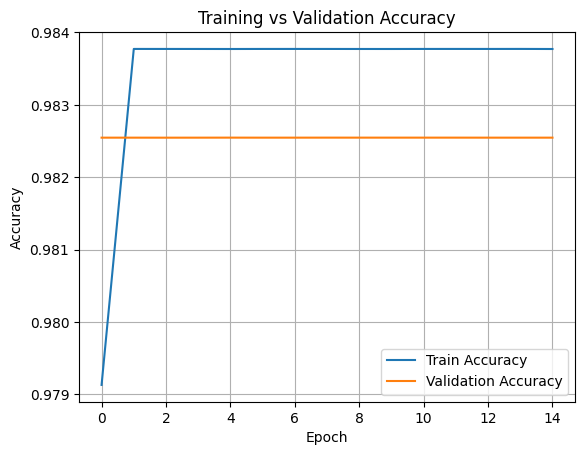

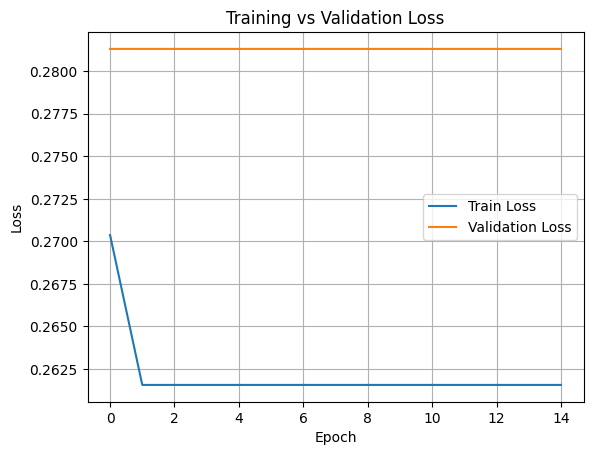

In [3]:
import matplotlib.pyplot as plt

# -----------------------------
# Accuracy Plot
# -----------------------------
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Loss Plot
# -----------------------------
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print("\nRunning segmentation evaluation on TEST set...\n")

y_true_all = []
y_pred_all = []

# Loop over test dataset
for images, masks in test_ds:
    preds = model.predict(images, verbose=0)

    # Threshold predictions
    preds = (preds > 0.5).astype(np.uint8)

    # Flatten
    y_true_all.extend(masks.numpy().flatten())
    y_pred_all.extend(preds.flatten())

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# ===========================================================
# CONFUSION MATRIX (PIXEL-WISE)
# ===========================================================
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Background", "Foreground"],
    yticklabels=["Background", "Foreground"]
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Pixel-wise Confusion Matrix (U-Net Segmentation)")
plt.tight_layout()
plt.show()



Running segmentation evaluation on TEST set...



2025-12-17 23:25:34.966527: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-12-17 23:25:47.719623: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
